# Lab 5


## JMuBEN2 dataset


(https://data.mendeley.com/datasets/tgv3zb82nd/1)

Image dataset taken from an Arabica coffee plantation. The image dataset contains collection of healthy and miner coffee leaves.

We used the same dataset that we used in Lab 4.

# Loading and Spliting the dataset 

In [1]:
import os
import requests
import zipfile
import numpy as np

dataset_url = 'https://github.com/ishaqmarashy/DATALFS/raw/main/JMuBEN.zip'
dataset_dir = './JMuBEN'

# create directory for dataset if it does not exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    
# append JMuBEN.zip to the end of the path (this is where we download the file to)
zip_file_path = os.path.join(dataset_dir, 'JMuBEN.zip')


# check if file is downloaded already
if not os.path.exists(zip_file_path):
    
    # file is not downloaded so fetch the file
    response = requests.get(dataset_url)
    
    # write file to storage which is recieved from the response
    with open(zip_file_path, 'wb') as zip_file:
        zip_file.write(response.content)
        
    # unzip to zip file path
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

# within the concat train and test to become ./JMuBEN/train and JMuBEN ./JMuBEN/test
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [2]:
def load_images_and_labels(directory):
    images = []
    labels = []
    
    # get subdirectories Healthy and Miner
    
    for class_name in os.listdir(directory):
        
        # concat subdirectory to get full path
        class_dir = os.path.join(directory, class_name)
        # assign labels using class subdirectory
        # label is determined by filepath
        label = 0 if class_name == 'Miner' else 1
        
        # append labels and image paths to labels and images respectively
        for filename in os.listdir(class_dir):
            images.append(os.path.join(class_dir, filename))
            labels.append(label)
            
    return images, labels

# load file directories and their labels
train_images_dir, train_labels = load_images_and_labels(train_dir)
test_images_dir, test_labels = load_images_and_labels(test_dir)

In [3]:
# print the number of images and labels

print(f"Train images:{len(train_images_dir)}  Labels:{len(train_labels)}")
print(f"Test images:{len(test_images_dir)}  Labels:{len(test_labels)}")


Train images:24000  Labels:24000
Test images:6000  Labels:6000


# Pre-processing and Normalization

Images in the dataset were converted to grayscale and resized to 128x128

Tried loading as described https://www.analyticsvidhya.com/blog/2021/07/step-by-step-guide-for-image-classification-on-custom-datasets/

https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156

In [4]:
import cv2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def load_grayscale_images(image_paths):
    loaded_images = []
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #  grayscale
        loaded_images.append(img)
    return loaded_images

def resize_images(images_to_resize):
    resized_images = []
    for img in images_to_resize:
        resized_img = cv2.resize(img, (128, 128))  # resize
        resized_images.append(resized_img)
    return resized_images

def normalize_image(images_to_normalize):
    normalized_images = []
    for img in images_to_normalize:
        normalized_img = img / 255.0  # normalize
        normalized_images.append(normalized_img)
    return normalized_images

image_pipeline = Pipeline(steps=[
    ('load_grayscale_images', FunctionTransformer(load_grayscale_images)),
    ('resize_images', FunctionTransformer(resize_images)),
    ('normalize_image', FunctionTransformer(normalize_image))
])


train_images=image_pipeline.transform(train_images_dir)
test_images=image_pipeline.transform(test_images_dir)

In [5]:
print(len(train_images))
print(len(test_images))

24000
6000


# Model Training

In [6]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)

train_images = train_images.reshape(train_images.shape[0], -1)
train_labels = train_labels.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

### 1) Multinomial Naive Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB
clf1 = MultinomialNB(alpha=1.0e-10, force_alpha=True , class_prior=[0.4, 0.6])
train_labels = train_labels.ravel()
clf1.fit(train_images, train_labels)
predictions1 = clf1.predict(test_images)

##### Model Evaluation


In [8]:
from sklearn.metrics import accuracy_score

# accuracy
accuracy = accuracy_score(test_labels, predictions1)
print('Accuracy = ', accuracy)

Accuracy =  0.6556666666666666


In [9]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions1)
confusion_matrix

array([[1068, 1932],
       [ 134, 2866]], dtype=int64)

In [10]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  1068
FP =  134
TN =  2866
FN =  1932


In [11]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.356
Specificity =  0.9553333333333334


In [12]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(test_labels, predictions1)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions1)
print('Recall = ', recall)

Precision =  0.5973322217590663
Recall =  0.9553333333333334


Area Under Curve =  0.5523554444444445


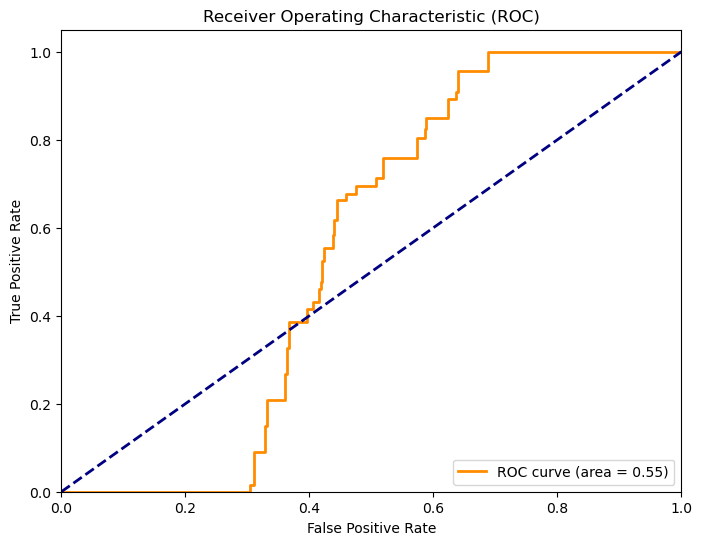

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate predicted probabilities for the positive class
probabilities = clf1.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 2) Gaussian Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()
clf2.fit(train_images, train_labels)
predictions2 = clf2.predict(test_images)

##### Model Evaluation


In [15]:
# accuracy
accuracy = accuracy_score(test_labels, predictions2)
print('Accuracy = ', accuracy)

Accuracy =  0.653


In [16]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions2)
confusion_matrix

array([[2316,  684],
       [1398, 1602]], dtype=int64)

In [17]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  2316
FP =  1398
TN =  1602
FN =  684


In [18]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.772
Specificity =  0.534


In [19]:
precision = precision_score(test_labels, predictions2)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions2)
print('Recall = ', recall)

Precision =  0.7007874015748031
Recall =  0.534


Area Under Curve =  0.782322


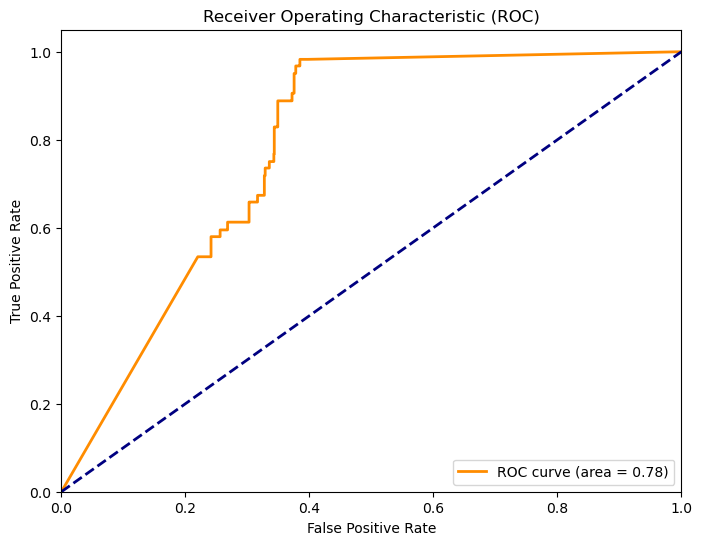

In [20]:
# Calculate predicted probabilities for the positive class
probabilities = clf2.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 3) Complement Naive Bayes

In [21]:
from sklearn.naive_bayes import ComplementNB
clf3 = ComplementNB(force_alpha=True)
clf3.fit(train_images, train_labels)
predictions3 = clf3.predict(test_images)

##### Model Evaluation


In [22]:
# accuracy
accuracy = accuracy_score(test_labels, predictions3)
print('Accuracy = ', accuracy)

Accuracy =  0.601


In [23]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions3)
confusion_matrix

array([[1331, 1669],
       [ 725, 2275]], dtype=int64)

In [24]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  1331
FP =  725
TN =  2275
FN =  1669


In [25]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.44366666666666665
Specificity =  0.7583333333333333


In [26]:
precision = precision_score(test_labels, predictions3)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions3)
print('Recall = ', recall)

Precision =  0.5768255578093306
Recall =  0.7583333333333333


Area Under Curve =  0.552383888888889


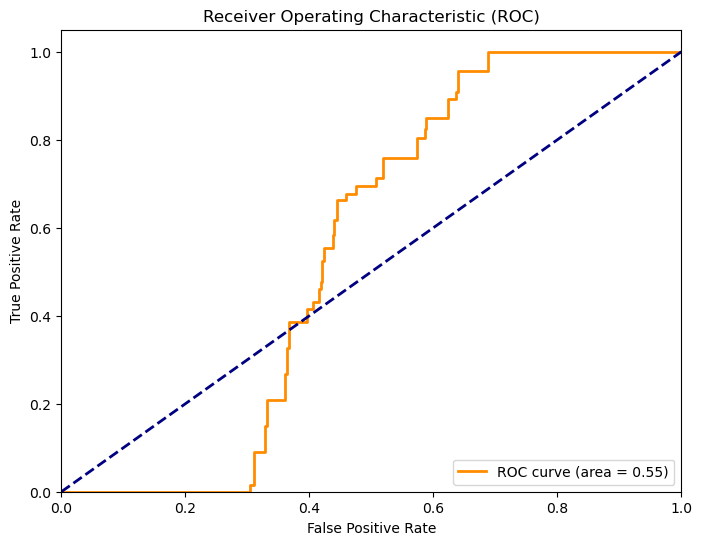

In [27]:
# Calculate predicted probabilities for the positive class
probabilities = clf3.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 4) Bernoulli Naive Bayes

In [28]:
from sklearn.naive_bayes import BernoulliNB
clf4 = BernoulliNB(force_alpha=True)
clf4.fit(train_images, train_labels)
predictions4 = clf4.predict(test_images)

##### Model Evaluation


In [29]:
# accuracy
accuracy = accuracy_score(test_labels, predictions4)
print('Accuracy = ', accuracy)

Accuracy =  0.5


In [30]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions4)
confusion_matrix

array([[3000,    0],
       [3000,    0]], dtype=int64)

In [31]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  3000
FP =  3000
TN =  0
FN =  0


In [32]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  1.0
Specificity =  0.0


In [33]:
precision = precision_score(test_labels, predictions4, zero_division=1)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions4, zero_division=1)
print('Recall = ', recall)

Precision =  1.0
Recall =  0.0


Area Under Curve =  0.5


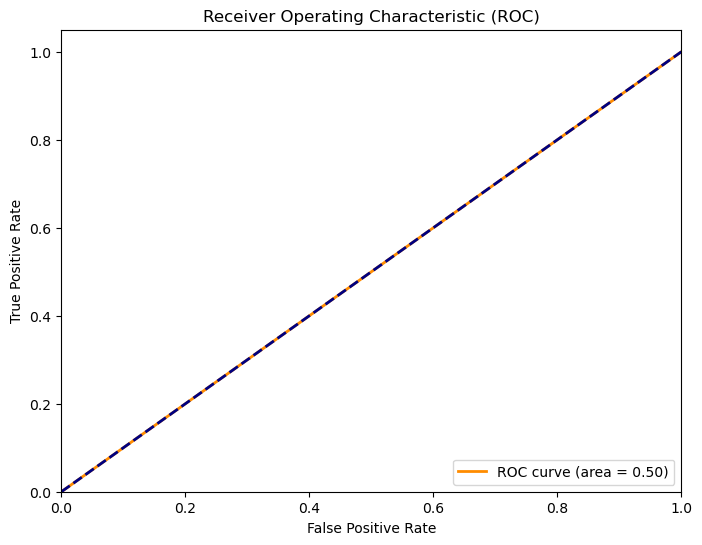

In [34]:
# Calculate predicted probabilities for the positive class
probabilities = clf4.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 5) Categorical Naive Bayes

In [35]:
from sklearn.naive_bayes import CategoricalNB
clf5 = CategoricalNB(force_alpha=True)
clf5.fit(train_images, train_labels)
predictions5 = clf5.predict(test_images)

##### Model Evaluation


In [36]:
# accuracy
accuracy = accuracy_score(test_labels, predictions5)
print('Accuracy = ', accuracy)

Accuracy =  0.6163333333333333


In [37]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions5)
confusion_matrix

array([[ 698, 2302],
       [   0, 3000]], dtype=int64)

In [38]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  698
FP =  0
TN =  3000
FN =  2302


In [39]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.23266666666666666
Specificity =  1.0


In [40]:
precision = precision_score(test_labels, predictions5)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions5)
print('Recall = ', recall)

Precision =  0.5658242172764995
Recall =  1.0


Area Under Curve =  0.6285


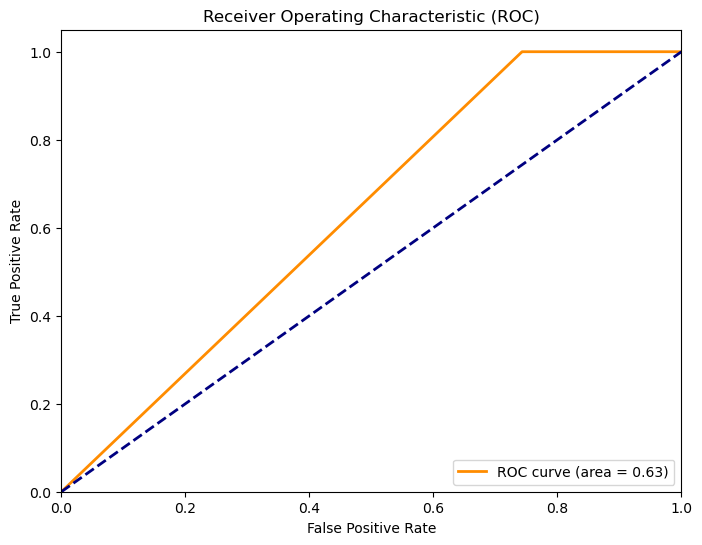

In [41]:
# Calculate predicted probabilities for the positive class
probabilities = clf5.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Clustering


## Finding The Optimal Number of Clusters

In [42]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=1,) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

In [43]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

X=test_images
y=test_labels
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

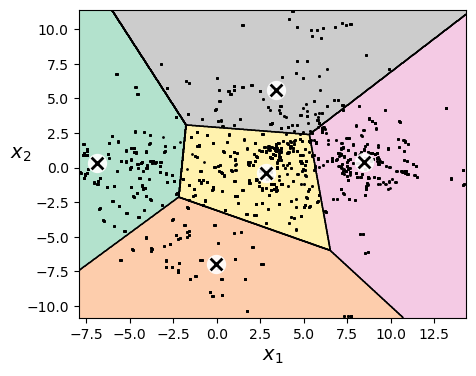

In [45]:
kmeans_rnd_10_inits_5_clusters = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="lloyd", random_state=11)
kmeans_rnd_10_inits_5_clusters.fit(X_pca)

plt.figure(figsize=(5, 4))
plot_decision_boundaries(kmeans_rnd_10_inits_5_clusters, X_pca)
plt.show()

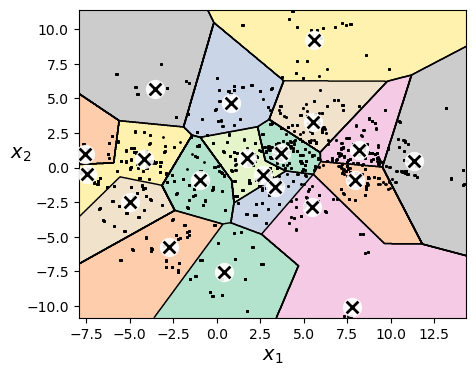

In [46]:
kmeans_rnd_10_inits = KMeans(n_clusters=20, init="random", n_init=10,
                              algorithm="lloyd", random_state=11)
kmeans_rnd_10_inits.fit(X_pca)

plt.figure(figsize=(5, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X_pca)
plt.show()

### Elbow Method

reference : https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/

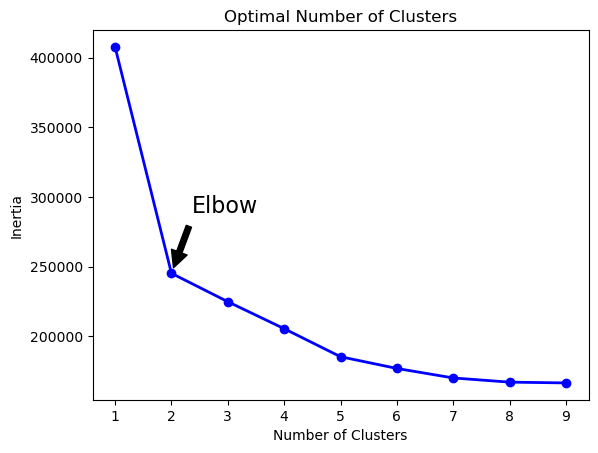

In [47]:
max_cluster=10
Sum_of_squared_distances = []
kmeans_per_k = [KMeans(n_clusters=k, random_state=42,n_init='auto').fit(X)
                for k in range(1, max_cluster)]
inertias = [model.inertia_ for model in kmeans_per_k]

K = range(1,max_cluster)
plt.annotate('Elbow',
             xy=(2, inertias[1]), 
             xytext=(0.3, 0.5),  
             textcoords='figure fraction',  
             fontsize=16,  
             arrowprops=dict(facecolor='black', shrink=0.1)  
            )

plt.plot(K,inertias,"bo-",linewidth=2)
plt.xlabel("Number of Clusters") 
plt.ylabel("Inertia") 
plt.title("Optimal Number of Clusters")
plt.show()

### Silhouette Score

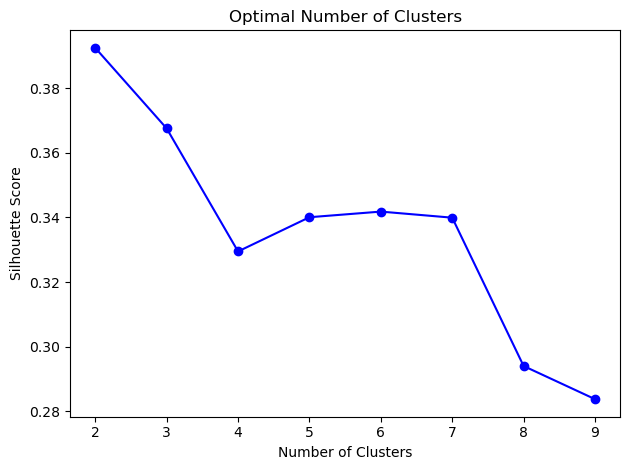

In [48]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]     

plt.plot(range(2, max_cluster), silhouette_scores, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters")
plt.tight_layout()
plt.show()

### David Bouldin Score

reference/credits:

https://www.geeksforgeeks.org/calinski-harabasz-index-cluster-validity-indices-set-3/

https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index

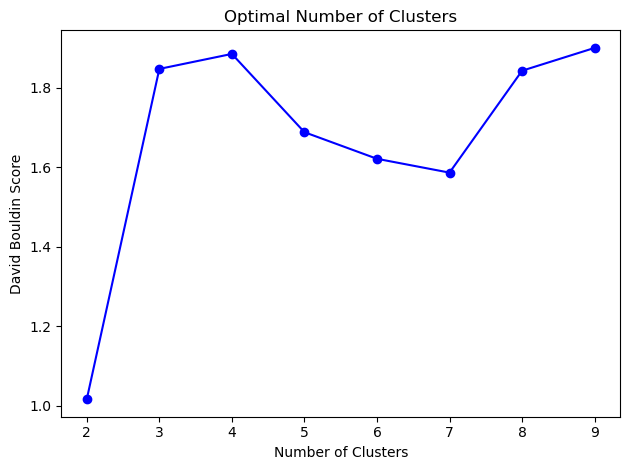

In [49]:
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

davies_bouldin_scores = [davies_bouldin_score(X, model.labels_) for model in kmeans_per_k[1:]]     

plt.plot(range(2, max_cluster), davies_bouldin_scores, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("David Bouldin Score")
plt.title("Optimal Number of Clusters")
plt.tight_layout()
plt.show()

### Variance Ratio Index

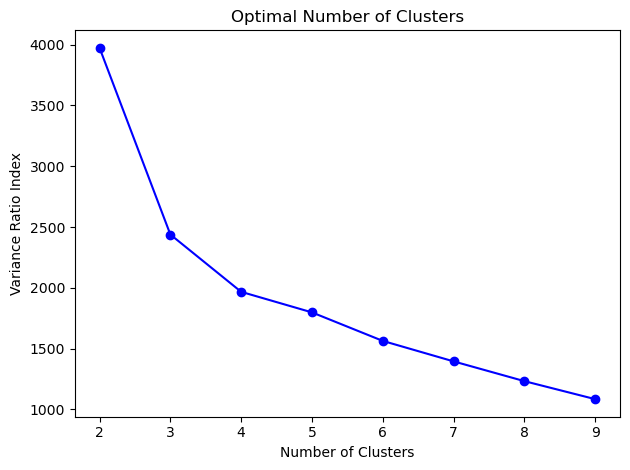

In [50]:
from sklearn.metrics import calinski_harabasz_score

calinski_harabasz_scores = [calinski_harabasz_score(X, model.labels_) for model in kmeans_per_k[1:]]     

plt.plot(range(2, max_cluster), calinski_harabasz_scores, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Variance Ratio Index")
plt.title("Optimal Number of Clusters")
plt.tight_layout()
plt.show()

### Conclusion

The optimal number of clusters is 2, which corresponds to the number of classes presented in the dataset: "Healthy" and "Miner." 

This decision is backed by:

    -The elbow method indicates that the optimal number of clusters is 2.

    -The highest silhouette score is achieved with 2 clusters.
    
    -The Davies-Bouldin Index demonstrates its lowest value of 1 when using 2 clusters.

## Similarity Measures

In [51]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

X_new = SelectKBest(chi2, k=20).fit_transform(X, y)
X_new.shape

(6000, 20)

## Feature Reduction 

### TSNE

In [52]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

### PCA

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


## Evaluation

### Metrics with reduced features

In [54]:
import pandas as pd
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def calculate_metrics(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]
    Sensitivity = TP / (TP + FN)
    Specificity = TN / (TN + FP)
    fpr= TP / (TP + FN)
    tpr= Sensitivity
    silhouette_scores = silhouette_score(X, y_pred)
    F1_score = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)
    Precision = precision_score(y, y_pred)
    Recall = recall_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)

    return fpr, tpr, TP, FP, TN, FN, Sensitivity, Specificity, Precision, Recall, roc_auc, accuracy, F1_score, silhouette_scores

In [55]:
def store_metrics_in_dataframe(y, y_pred):
    metrics = calculate_metrics(y, y_pred)
    metrics_df = pd.DataFrame({
        'FPR': [metrics[0]],
        'TPR': [metrics[1]],
        'TP': [metrics[2]],
        'FP': [metrics[3]],
        'TN': [metrics[4]],
        'FN': [metrics[5]],
        'Sensitivity': [metrics[6]],
        'Specificity': [metrics[7]],
        'Precision': [metrics[8]],
        'Recall': [metrics[9]],
        'ROC_AUC': [metrics[10]],
        'Accuracy': [metrics[11]],
        'F1_Score': [metrics[12]],
        'Silhouette_Scores': [metrics[13]]
    })

    return metrics_df

In [56]:
import pandas as pd
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def calculate_metrics(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]
    Sensitivity = TP / (TP + FN)
    Specificity = TN / (TN + FP)
    fpr= TP / (TP + FN)
    tpr= Sensitivity
    silhouette_scores = silhouette_score(X, y_pred)
    F1_score = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)
    Precision = precision_score(y, y_pred)
    Recall = recall_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)

    return fpr, tpr, TP, FP, TN, FN, Sensitivity, Specificity, Precision, Recall, roc_auc, accuracy, F1_score, silhouette_scores

def evaluate_unsupervised(algorithms,X):
    results = []
    for name, algorithm in algorithms:
        cluster_labels = algorithm.fit_predict(X)
        fpr, tpr, TP, FP, TN, FN, Sensitivity, Specificity, Precision, Recall, roc_auc, accuracy, F1_score, silhouette_score_ = calculate_metrics(y, cluster_labels)
        print(name,' Done')
        results.append({
            'Algorithm': name,
            'Silhouette Score': silhouette_score_,
            'TPR': tpr,
            'FPR': fpr,
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN,
            'Sensitivity': Sensitivity,
            'Specificity': Specificity,
            'Precision': Precision,
            'Recall': Recall,
            'ROC_AUC': roc_auc,
            'Accuracy': accuracy,
            'F1-Score': F1_score,
            'algorithm': algorithm
        })
    return pd.DataFrame(results)

In [57]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.cluster import DBSCAN

k_clusters=2

algorithms = [
    ('GaussianMixture', GaussianMixture(n_components=k_clusters, random_state=42)),
    ('KMeans', KMeans(n_clusters=k_clusters, n_init="auto", random_state=42)),
    ('MiniBatchKMeans', MiniBatchKMeans(n_clusters=k_clusters, batch_size=1536 , init='k-means++', n_init=50, random_state=42)), 
    ('AgglomerativeClustering', AgglomerativeClustering(n_clusters=k_clusters))
]

In [58]:
# GaussianNB
store_metrics_in_dataframe(y,clf1.predict(X))

,FPR,TPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1_Score,Silhouette_Scores
0,0.955333,0.955333,2866,1932,1068,134,0.955333,0.356,0.597332,0.955333,0.655667,0.655667,0.73506,0.11396


In [59]:
# MultinomialNB
store_metrics_in_dataframe(y,clf2.predict(X))


,FPR,TPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1_Score,Silhouette_Scores
0,0.534,0.534,1602,684,2316,1398,0.534,0.772,0.700787,0.534,0.653,0.653,0.606129,0.377594


In [60]:
# ComplementNB
store_metrics_in_dataframe(y,clf3.predict(X))

,FPR,TPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1_Score,Silhouette_Scores
0,0.758333,0.758333,2275,1669,1331,725,0.758333,0.443667,0.576826,0.758333,0.601,0.601,0.655242,0.115363


In [61]:
results_df_full_feature = evaluate_unsupervised(algorithms,X)
results_df_full_feature

GaussianMixture  Done
KMeans  Done
MiniBatchKMeans  Done
AgglomerativeClustering  Done


,Algorithm,Silhouette Score,TPR,FPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1-Score,algorithm
0,GaussianMixture,0.392455,0.466,0.466,1398,2169,831,1602,0.466,0.277000,0.391926,0.466,0.371500,0.371500,0.425765,"GaussianMixture(n_components=2, random_state=42)"
1,KMeans,0.392455,0.466,0.466,1398,2169,831,1602,0.466,0.277000,0.391926,0.466,0.371500,0.371500,0.425765,"KMeans(n_clusters=2, n_init='auto', random_sta..."
2,MiniBatchKMeans,0.393025,0.534,0.534,1602,799,2201,1398,0.534,0.733667,0.667222,0.534,0.633833,0.633833,0.593223,"MiniBatchKMeans(batch_size=1536, n_clusters=2,..."
3,AgglomerativeClustering,0.383456,0.534,0.534,1602,515,2485,1398,0.534,0.828333,0.756731,0.534,0.681167,0.681167,0.626148,AgglomerativeClustering()


In [62]:
results_df_2tsne = evaluate_unsupervised(algorithms,X_tsne)
results_df_2tsne

GaussianMixture  Done
KMeans  Done
MiniBatchKMeans  Done
AgglomerativeClustering  Done


,Algorithm,Silhouette Score,TPR,FPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1-Score,algorithm
0,GaussianMixture,0.042619,0.456667,0.456667,1370,1572,1428,1630,0.456667,0.476000,0.465670,0.456667,0.466333,0.466333,0.461124,"GaussianMixture(n_components=2, random_state=42)"
1,KMeans,0.033578,0.437000,0.437000,1311,1662,1338,1689,0.437000,0.446000,0.440969,0.437000,0.441500,0.441500,0.438975,"KMeans(n_clusters=2, n_init='auto', random_sta..."
2,MiniBatchKMeans,0.183796,0.287000,0.287000,861,2083,917,2139,0.287000,0.305667,0.292459,0.287000,0.296333,0.296333,0.289704,"MiniBatchKMeans(batch_size=1536, n_clusters=2,..."
3,AgglomerativeClustering,0.078634,0.560333,0.560333,1681,739,2261,1319,0.560333,0.753667,0.694628,0.560333,0.657000,0.657000,0.620295,AgglomerativeClustering()


In [63]:
results_df_2pca = evaluate_unsupervised(algorithms,X_pca)
results_df_2pca

GaussianMixture  Done
KMeans  Done
MiniBatchKMeans  Done
AgglomerativeClustering  Done


,Algorithm,Silhouette Score,TPR,FPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1-Score,algorithm
0,GaussianMixture,0.336431,0.534,0.534,1602,24,2976,1398,0.534,0.992000,0.985240,0.534,0.763000,0.763000,0.692607,"GaussianMixture(n_components=2, random_state=42)"
1,KMeans,0.393031,0.534,0.534,1602,795,2205,1398,0.534,0.735000,0.668335,0.534,0.634500,0.634500,0.593663,"KMeans(n_clusters=2, n_init='auto', random_sta..."
2,MiniBatchKMeans,0.393031,0.534,0.534,1602,795,2205,1398,0.534,0.735000,0.668335,0.534,0.634500,0.634500,0.593663,"MiniBatchKMeans(batch_size=1536, n_clusters=2,..."
3,AgglomerativeClustering,0.384317,0.534,0.534,1602,506,2494,1398,0.534,0.831333,0.759962,0.534,0.682667,0.682667,0.627251,AgglomerativeClustering()


## Plots

### Hard Clustering

Ref https://github.com/scikit-learn/scikit-learn/blob/main/examples/mixture/plot_gmm_pdf.py

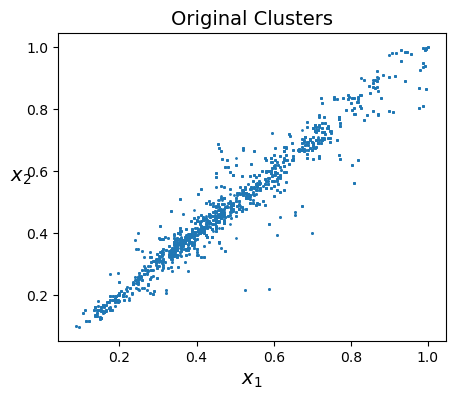

In [64]:
plt.figure(figsize=(5,4))
plt.title('Original Clusters', fontsize = 14)
plot_clusters(X)
plt.show()

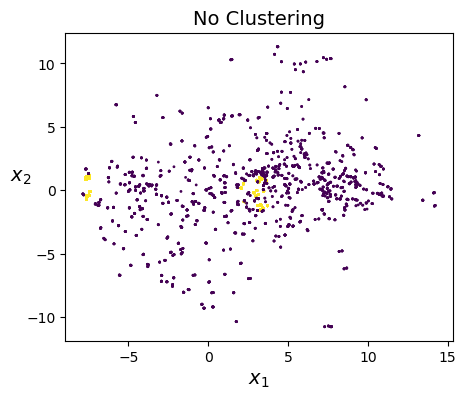

In [65]:
#No k-means applied on pca reduced dataset
plt.figure(figsize=(5,4))
plt.title('No Clustering', fontsize = 14)
plot_clusters(X_pca, y)
plt.show()

In [66]:
def get_model(df,model):
    return df[df['Algorithm'] == model]['algorithm'].iloc[0]

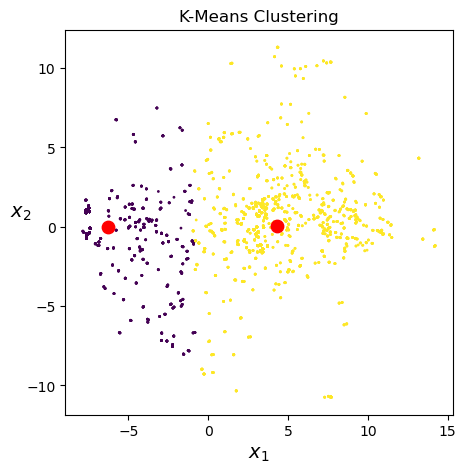

In [67]:
kmeans = get_model(results_df_full_feature,'KMeans')
y_pred = kmeans.fit_predict(X)
centroid_points = pca.transform(kmeans.cluster_centers_)
point1 = centroid_points[:, 0]
point2= centroid_points[:, 1]

#plotting the clusters and their centroids

plt.figure(figsize=(5, 5))
plt.title("K-Means Clustering")
plot_clusters(X_pca, y_pred)
plt.scatter(point1,point2 , c='red', s=80, marker='o')
plt.show()

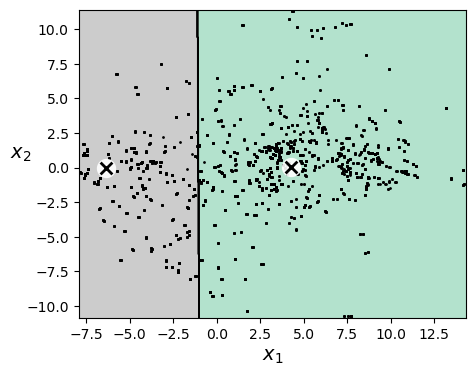

In [68]:
kmeans_reduction_pca = get_model(results_df_2pca,'KMeans').fit(X_pca)

# plot decision boundary with reduced dataset

plt.figure(figsize=(5, 4))
plot_decision_boundaries(kmeans_reduction_pca, X_pca)
plt.show()



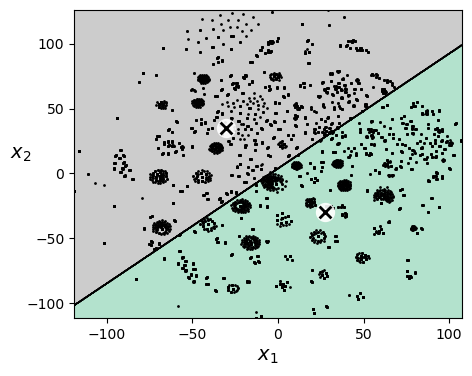

In [69]:
# plot decision boundary with reduced dataset  

plt.figure(figsize=(5, 4))
X_tsne = X_tsne.astype('float64')
kmeans_tsne_reduction =  get_model(results_df_2tsne,'KMeans').fit(X_tsne)
plot_decision_boundaries(kmeans_tsne_reduction,X_tsne)
plt.show()

### Soft Clustering

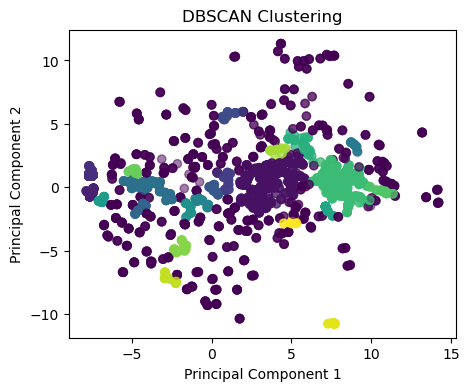

In [70]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


dbscan_model = DBSCAN(eps=0.5, min_samples=20)  
dbscan_model.fit(X_pca)


dbscan_labels = dbscan_model.labels_
plt.figure(figsize=(5, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [71]:
X_dataframe=pd.DataFrame(X)
def scatter_plot(clusters, title):
    plt.title(title)
    for c in range(clusters.n_clusters):
        cluster = X_dataframe.iloc[clusters.labels_ == c]
        plt.scatter(cluster.iloc[:, 0], cluster.iloc[:, 1], label="Cluster " + str(c), alpha=0.1)
    plt.legend()

In [72]:
ward_pca = get_model(results_df_2pca,'AgglomerativeClustering').fit(X_pca)
kmeans_miniBatch = get_model(results_df_2pca,'MiniBatchKMeans').fit(X_pca)
gaussianMixture  = get_model(results_df_2pca,'GaussianMixture').fit(X_pca)

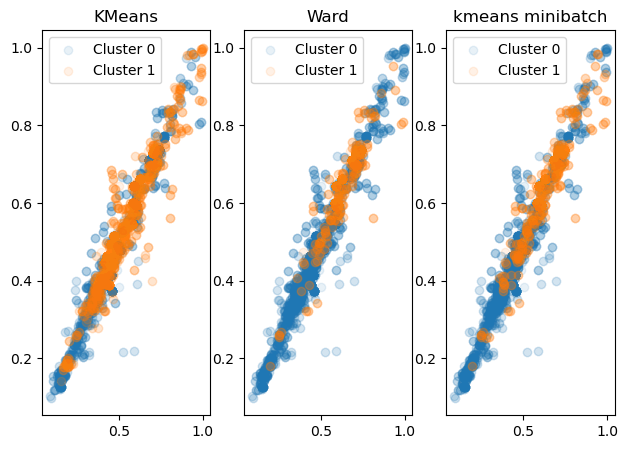

In [73]:
plt.figure(figsize=(10, 5))

plt.subplot(1,4,1)
scatter_plot(kmeans_reduction_pca, "KMeans")

plt.subplot(1,4,2)
scatter_plot(ward_pca, "Ward")

plt.subplot(1,4,3)
scatter_plot(kmeans_miniBatch, "kmeans minibatch")



##### Referenced : https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py

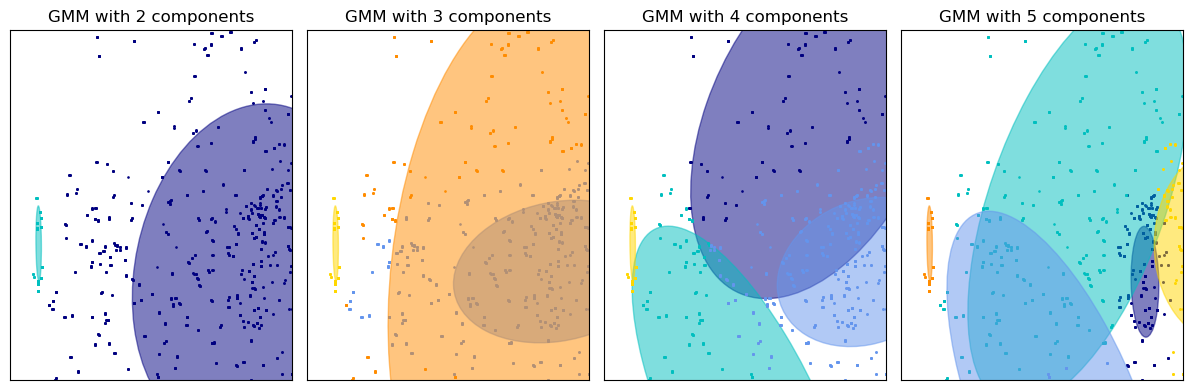

In [74]:
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 5, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9.0, 5.0)
    plt.ylim(-3.0, 6.0)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

fig = plt.figure(figsize=(15, 4)) 

for i in range(2, 6): 
    gmm = mixture.GaussianMixture(n_components=i, covariance_type="full").fit(X_pca)
    plot_results(X_pca, gmm.predict(X_pca), gmm.means_, gmm.covariances_, i - 1, f"GMM with {i} components")

plt.tight_layout()
plt.show()
